# Machine Learning II

### Autores: Verónica Gómez, Carlos Grande y Pablo Olmos.

Planteamiento de la metodología. Trabajaremos con la base de datos de Casas de los anteriores trimestres. Nuestro objetivo fundamental será implementar los conocimientos adquiridos en la materia de ML_II e intentar mejorar los resultados de los modelos anteriores si fuera posible.
Trabajaremos con Redes Neuronales en la Librería Pytorch de Python y partiremos de la misma partición Control, Validación y Test que en el trimestre anterior.

#  índice global
### 1.- Red Binaria
### 2.- Red Clasificador Múltiple
### 3.- CNN
### 4.- SMOTE
### 5.- Problema sintético multiclase desequilibrado
### 
### 

## 1.-Red Binaria 

Objetivo, Binario 1/0 definido por el percentil 75 de la variable Price de la Base de datos dada que determina aquellas viviendas de precio más elevado.

###  índice
##### 1.1.- Importamos la BBDD
##### 1.2.- EDA html
##### 1.3.- Tratamiento de Variables. Limpieza y preparación
##### 1.4.- Split Train, Validation, Test
##### 1.5.- Transformación de la Escala de los Datos
##### 1.6.- Definición de los parámetros de aprendizaje de la Red Neuronal
##### 1.7.- Validaciones y Conclusiones
##### 1.8.- Tree after Net. Modelos Subrogados Global
##### 
##### 

#### 1.1.- Importamos la BBDD
Seleccionamos los ficheros generados de forma alaeatoria en el trimestre anterior.

In [341]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
import sweetviz as sv
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#Import the DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [342]:
# load the dataset
df = pd.read_csv('cluster.txt', sep=",")
df.head()

,Unnamed: 0,X.1,X,Y,id,date,price,bedrooms,bathrooms,sqft_living,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,cluster,hclust,Cluster_final
0,1,1,3.762164,22.445021,7129300520,10/13/2014,221900.0,3,1.00,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,1,1,low
1,2,2,-24.035975,9.766915,6414100192,12/9/2014,538000.0,3,2.25,2570,...,1951,1991,98125,47.7210,-122.319,1690,7639,1,2,top
2,3,3,5.217015,8.102678,5631500400,2/25/2015,180000.0,2,1.00,770,...,1933,0,98028,47.7379,-122.233,2720,8062,1,3,med
3,4,4,7.588730,18.967730,2487200875,12/9/2014,604000.0,4,3.00,1960,...,1965,0,98136,47.5208,-122.393,1360,5000,2,1,low
4,5,5,0.666181,3.939548,1954400510,2/18/2015,510000.0,3,2.00,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,3,3,med


In [343]:
y= np.where(df['price']>=645000, 1, 0)

#### 1.2.- EDA html

In [235]:
#analyzing the dataset
advert_report = sv.analyze(df)
#display the report
advert_report.show_html('Advertising.html')

:FEATURES DONE:                    |                     | [  0%]   00:39  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:07  -> (00:00 left)


Creating Associations graph... DONE!


#### 1.3.- Tratamiento de Variables. Limpieza y preparación
Vamos a realizar un pequeño tratamiento de los datos para poder trabajar con redes Neuronales. Tenemos que tratar las variables fechas y las categóricas transformarlas a Dummy u ordinales. 
Para la variable Cluster Final que es la categórica que vamos a tratar realizaremos una trasnformación a Dummy para no darle un peso irreal si realizamos una transformación ordinal. 

In [344]:
# tratamiento de la Variable Cluster a Nivel Dummy
dummy=pd.get_dummies(df['Cluster_final'])
df=pd.concat([df,dummy],axis=1)

In [345]:
# tratamiento yr_renovated a flag 
df['renova'] = np.where(df['yr_renovated']>0, 1, 0)

In [346]:
# tratamiento yr_built Numero de anyos de la vivienda
df['max_year']     = max(df['yr_built'])
df['anyos']=(df['max_year'] -df['yr_built'])

In [347]:
# Tratamiento de las fechas, crearemos una variable llamada Antigüedad en días de una vivienda 
#con respecto a la máxima fecha de la base de datos.
df['max']     = max(df['date'])
df['max']     = pd.to_datetime(df['max'] )
df['date']    = pd.to_datetime(df['date'])
df['antiguedad']=(df['date'] -df['max']).apply(lambda x: x.days)

Ahora vamos a limpiar algunas variables que son redundantes o no tienen sentido en el análisis.

In [348]:
del df['date']
del df['max_year']
del df['max']
del df['cluster'] # eliminamos los otros análisis clústers
del df['hclust']
del df['price']
del df['Cluster_final']
del df['yr_renovated']
del df['yr_built']
df=df.set_index('id')
X=df.iloc[:, 4:30]
X.head(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,low,med,top,renova,anyos,antiguedad
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,47.5112,-122.257,1340,5650,1,0,0,0,60,34
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,47.7210,-122.319,1690,7639,0,0,1,1,64,91
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,47.7379,-122.233,2720,8062,0,1,0,0,82,169
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,47.5208,-122.393,1360,5000,1,0,0,0,50,91
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,47.6168,-122.045,1800,7503,0,1,0,0,28,162


#### 1.4.- Split Train, Validation, Test.

In [349]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=737)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval,random_state=737)

#### 1.5.- Transformación de la Escala de los Datos

In [350]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

#### 1.6.- Definición de los parámetros de aprendizaje de la Red Neuronal

In [351]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [352]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))


## val data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

val_data = testData(torch.FloatTensor(X_val))


## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))


In [378]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(dataset=val_data, batch_size=1)
test_loader  = DataLoader(dataset=test_data, batch_size=1)

In [379]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 22.
        self.layer_1 = nn.Linear(22, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [380]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [381]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=22, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [382]:
def binary_acc(y_pred, y_val):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_val).sum().float()
    acc = correct_results_sum/y_val.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [385]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.32051 | Acc: 87.407
Epoch 002: | Loss: 0.24113 | Acc: 89.992
Epoch 003: | Loss: 0.20847 | Acc: 91.222
Epoch 004: | Loss: 0.19554 | Acc: 91.514
Epoch 005: | Loss: 0.18782 | Acc: 92.160
Epoch 006: | Loss: 0.18229 | Acc: 92.280
Epoch 007: | Loss: 0.17537 | Acc: 92.494
Epoch 008: | Loss: 0.17550 | Acc: 92.621
Epoch 009: | Loss: 0.17009 | Acc: 92.733
Epoch 010: | Loss: 0.16944 | Acc: 92.687
Epoch 011: | Loss: 0.17084 | Acc: 92.811
Epoch 012: | Loss: 0.16609 | Acc: 92.930
Epoch 013: | Loss: 0.16309 | Acc: 93.066
Epoch 014: | Loss: 0.16208 | Acc: 93.173
Epoch 015: | Loss: 0.16116 | Acc: 93.095
Epoch 016: | Loss: 0.16006 | Acc: 93.136
Epoch 017: | Loss: 0.15650 | Acc: 93.354
Epoch 018: | Loss: 0.15778 | Acc: 93.387
Epoch 019: | Loss: 0.15668 | Acc: 93.391
Epoch 020: | Loss: 0.15577 | Acc: 93.486
Epoch 021: | Loss: 0.15054 | Acc: 93.716
Epoch 022: | Loss: 0.15266 | Acc: 93.704
Epoch 023: | Loss: 0.14963 | Acc: 93.749
Epoch 024: | Loss: 0.14487 | Acc: 93.815
Epoch 025: | Los

In [386]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

#### 1.7.- Validaciones y Conclusiones

In [373]:
confusion_matrix(y_test, y_pred_list)

array([[3141,   97],
       [ 197,  885]])

In [374]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3238
           1       0.90      0.82      0.86      1082

    accuracy                           0.93      4320
   macro avg       0.92      0.89      0.91      4320
weighted avg       0.93      0.93      0.93      4320



Observamos que nuestro Accuracy es 0.92, es muy buen resultado así como los f1-score y recall.

#### 1.8.- Tree after Net. Modelos Subrogados Global

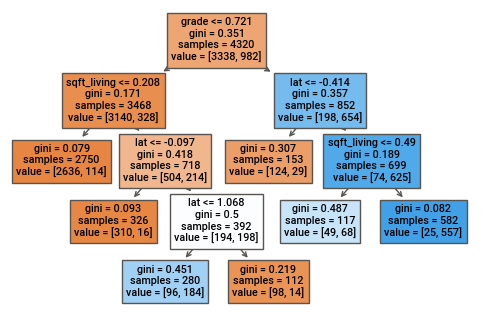

In [375]:
clf = DecisionTreeClassifier(max_leaf_nodes=7).fit(X_test, y_pred_list)
plot_tree(clf, filled=True,feature_names=X.columns) #names 
plt.show()

Las variables más determinantes para explicar la variabilidad del Cluster dentro de nuestros datos son...
##### Grado de estado de la vicienda
##### Posicionamiento Geográfico
##### Metros Cuadrados

## 2.-Red Clasificador Múltiple

Objetivo, Multiclase definido por la variable Cluster Final creada en la práctica de la asignatura ML I con tres categorías Low, Med y Top. 

###  índice
##### 2.1.- Importamos la BBDD
##### 2.2.- EDA html
##### 2.3.- Tratamiento de Variables. Limpieza y preparación
##### 2.4.- Split Train, Validation, Test
##### 2.5.- Transformación de la Escala de los Datos
##### 2.6.- Definición de los parámetros de aprendizaje de la Red Neuronal
##### 2.7.- Validaciones y Conclusiones
##### 2.8.- Nueva Red y conclusiones
##### 2.9.- Modelos Subrogados Global. Tree after Net
##### 
##### 

#### 2.1.- Importamos la BBDD

In [336]:
# load the dataset
df2 = pd.read_csv('cluster.txt', sep=",")
df2.head()

,Unnamed: 0,X.1,X,Y,id,date,price,bedrooms,bathrooms,sqft_living,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,cluster,hclust,Cluster_final
0,1,1,3.762164,22.445021,7129300520,10/13/2014,221900.0,3,1.00,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,1,1,low
1,2,2,-24.035975,9.766915,6414100192,12/9/2014,538000.0,3,2.25,2570,...,1951,1991,98125,47.7210,-122.319,1690,7639,1,2,top
2,3,3,5.217015,8.102678,5631500400,2/25/2015,180000.0,2,1.00,770,...,1933,0,98028,47.7379,-122.233,2720,8062,1,3,med
3,4,4,7.588730,18.967730,2487200875,12/9/2014,604000.0,4,3.00,1960,...,1965,0,98136,47.5208,-122.393,1360,5000,2,1,low
4,5,5,0.666181,3.939548,1954400510,2/18/2015,510000.0,3,2.00,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,3,3,med


Viendo la ditribución de la variable.

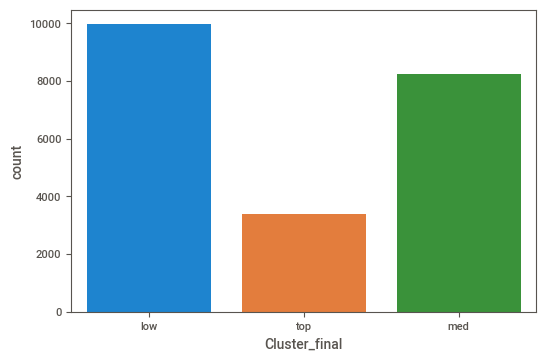

In [339]:
sns.countplot(x = 'Cluster_final', data=df2)

#### 2.2.- EDA html

In [340]:
#analyzing the dataset
#advert_report = sv.analyze(df2)
#display the report
#advert_report.show_html('Advertising.html')

#### 2.3.- Tratamiento de Variables. Limpieza y preparación
Vamos a realizar un pequeño tratamiento de los datos para poder trabajar con redes Neuronales. Tenemos que tratar las variables fechas y las categóricas transformarlas a Dummy u ordinales. 
Para la variable Cluster Final que es la categórica que vamos a tratar realizaremos una trasnformación a Ordinal ya que es nuestra variable objetivo.
Recalcularemos fechas y generaremos variables Flags.
En este análisis vamos a mantener la variable Price.

In [281]:
enc = OrdinalEncoder()
df2[["Cluster_final"]] = enc.fit_transform(df2[["Cluster_final"]])
df2['Cluster_final'] .value_counts()

0.0    9970
1.0    8225
2.0    3402
Name: Cluster_final, dtype: int64

In [282]:
# tratamiento yr_renovated a flag 
df2['renova'] = np.where(df2['yr_renovated']>0, 1, 0)

In [283]:
# tratamiento yr_built Numero de anyos de la vivienda
df2['max_year']     = max(df2['yr_built'])
df2['anyos']=(df2['max_year'] -df2['yr_built'])

In [284]:
# Tratamiento de las fechas, crearemos una variable llamada Antigüedad en días de una vivienda 
#con respecto a la máxima fecha de la base de datos.
df2['max']     = max(df2['date'])
df2['max']     = pd.to_datetime(df2['max'] )
df2['date']    = pd.to_datetime(df2['date'])
df2['antiguedad']=(df2['date'] -df2['max']).apply(lambda x: x.days)

In [285]:
del df2['date']
del df2['max_year']
del df2['max']
del df2['cluster'] # eliminamos los otros análisis clústers
del df2['hclust']
del df2['yr_renovated']
del df2['yr_built']
df2=df2.set_index('id')
X=df2.iloc[:, 4:30]
X.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,Cluster_final,renova,anyos,antiguedad
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,1340,5650,0.0,0,60,34
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,400,98125,47.7210,-122.319,1690,7639,2.0,1,64,91
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,2720,8062,1.0,0,82,169
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,98136,47.5208,-122.393,1360,5000,0.0,0,50,91
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,1800,7503,1.0,0,28,162


La variable Cluster Final la sacamos del df X a estudio

In [286]:
y=X['Cluster_final']
del X['Cluster_final']

In [287]:
y

id
7129300520    0.0
6414100192    2.0
5631500400    1.0
2487200875    0.0
1954400510    1.0
             ... 
263000018     1.0
6600060120    1.0
1523300141    1.0
291310100     0.0
1523300157    1.0
Name: Cluster_final, Length: 21597, dtype: float64

#### 2.4.- Split Train, Validation, Test.

In [288]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=737)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval,random_state=737)

#### 2.5.- Transformación de la Escala de los Datos

In [289]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### 2.6.- Definición de los parámetros de aprendizaje de la Red Neuronal

In [290]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3

In [291]:
NUM_FEATURES

20

In [292]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset   = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset  = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [293]:
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE)
val_loader   = DataLoader(dataset=val_dataset, batch_size=1)
test_loader  = DataLoader(dataset=test_dataset, batch_size=1)

In [295]:
#softmax forward TODO

In [296]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) ## parametrizado al número de clases
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [297]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [298]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=20, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [299]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100   
    return acc

In [300]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [301]:
print("training...")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

training...


Epoch 001: | Train Loss: 0.37685 | Val Loss: 0.26448 | Train Acc: 99.486| Val Acc: 87.905
Epoch 002: | Train Loss: 0.31180 | Val Loss: 0.25111 | Train Acc: 100.000| Val Acc: 88.484
Epoch 003: | Train Loss: 0.28993 | Val Loss: 0.24016 | Train Acc: 100.000| Val Acc: 88.542
Epoch 004: | Train Loss: 0.27340 | Val Loss: 0.23698 | Train Acc: 100.000| Val Acc: 88.947
Epoch 005: | Train Loss: 0.25949 | Val Loss: 0.25468 | Train Acc: 100.000| Val Acc: 87.963
Epoch 006: | Train Loss: 0.24913 | Val Loss: 0.23329 | Train Acc: 100.000| Val Acc: 89.005
Epoch 007: | Train Loss: 0.23905 | Val Loss: 0.22446 | Train Acc: 100.000| Val Acc: 88.773
Epoch 008: | Train Loss: 0.22946 | Val Loss: 0.22884 | Train Acc: 100.000| Val Acc: 89.236
Epoch 009: | Train Loss: 0.22159 | Val Loss: 0.22978 | Train Acc: 100.000| Val Acc: 89.005
Epoch 010: | Train Loss: 0.21461 | Val Loss: 0.22323 | Train Acc: 100.000| Val Acc: 89.583
Epoch 011: | Train Loss: 0.20450 | Val Loss: 0.22172 | Train Acc: 100.000| Val Acc: 89.931


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

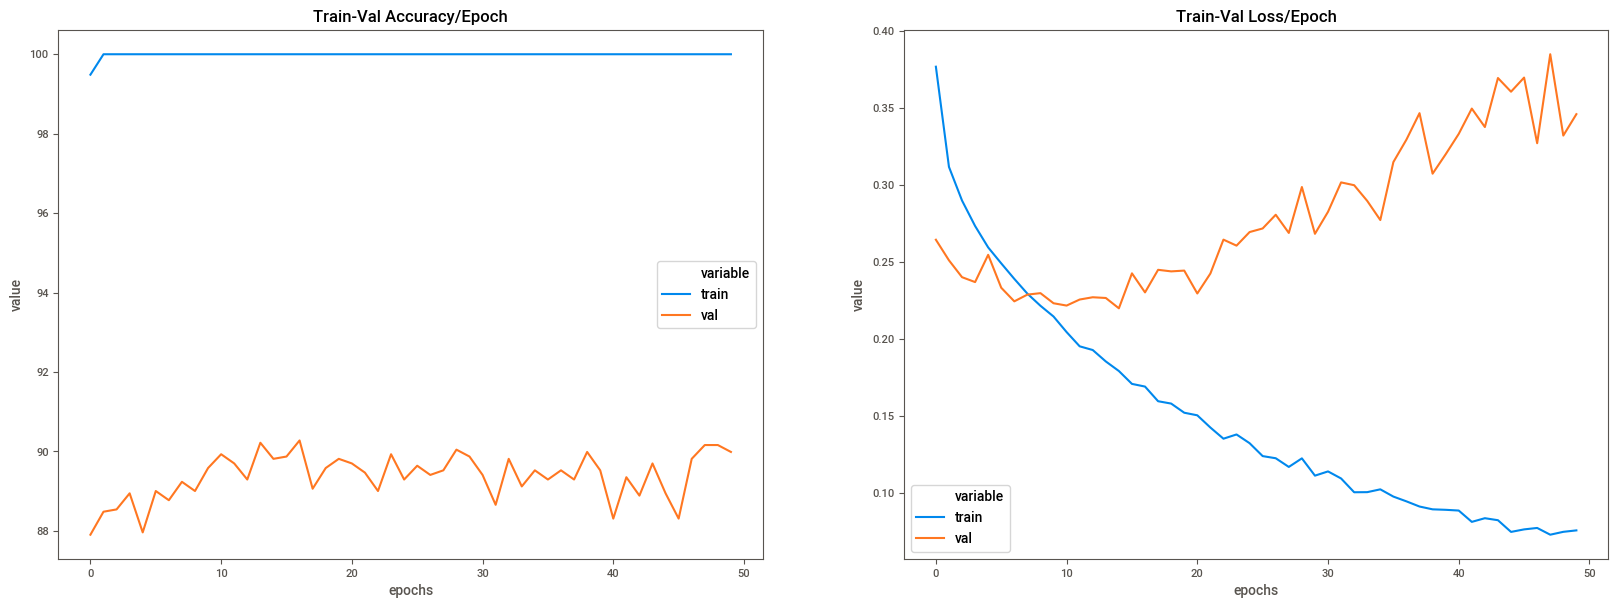

In [302]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Analizando la salida de las gráficas de Loss vemos que podemos plantearnos reentrenar el modelo con un número menor de Epochs, por ejemplo 20. También podemos plantearlos Regularización incrementando la Probabilidad del Dropout o un modelo más pequeño con menos capas o neuronas.

In [303]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

#### 2.7.- Validaciones y Conclusiones

In [304]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
confusion_matrix_df

,0,1,2
0,1908,79,7
1,139,1425,81
2,5,132,544


In [305]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      1994
         1.0       0.87      0.87      0.87      1645
         2.0       0.86      0.80      0.83       681

    accuracy                           0.90      4320
   macro avg       0.89      0.87      0.88      4320
weighted avg       0.90      0.90      0.90      4320



Las conclusiones del análisis son que funciona bastante bien a nivel accuracy el modelo pero sobre todo estamos satisfechos de la capacidad de predicción de la categoŕia Top, que es la menor, con un recall muy alto. 
Podemos concluir que la metodología es válida para el análisis de nuestros datos pero nos planteamos alternativas para evitar Overfitting.

#### 2.8.- Nueva Red y conclusiones
menos Epoch=20 
Regularizacón incrementando la probabilidad del Dropout para aumentar el Overfitting, el objetivo es desactivar neuronas para evitar el sobreajuste debido a un número de neuronas o capas muy grandes. 

In [306]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) ## parametrizado al número de clases
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) ## aumentamos el Dropout a 0.5
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [310]:
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3

In [311]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=20, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [312]:
print("training...")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

training...


Epoch 001: | Train Loss: 0.43777 | Val Loss: 0.27071 | Train Acc: 98.868| Val Acc: 87.847
Epoch 002: | Train Loss: 0.35037 | Val Loss: 0.26189 | Train Acc: 99.897| Val Acc: 88.542
Epoch 003: | Train Loss: 0.33082 | Val Loss: 0.26170 | Train Acc: 99.897| Val Acc: 88.715
Epoch 004: | Train Loss: 0.30993 | Val Loss: 0.24132 | Train Acc: 99.794| Val Acc: 89.062
Epoch 005: | Train Loss: 0.30146 | Val Loss: 0.24548 | Train Acc: 100.000| Val Acc: 88.889
Epoch 006: | Train Loss: 0.29105 | Val Loss: 0.23593 | Train Acc: 99.897| Val Acc: 89.583
Epoch 007: | Train Loss: 0.28429 | Val Loss: 0.23611 | Train Acc: 100.000| Val Acc: 89.005
Epoch 008: | Train Loss: 0.28171 | Val Loss: 0.23200 | Train Acc: 100.000| Val Acc: 89.236
Epoch 009: | Train Loss: 0.27079 | Val Loss: 0.23907 | Train Acc: 100.000| Val Acc: 88.368
Epoch 010: | Train Loss: 0.26347 | Val Loss: 0.22428 | Train Acc: 100.000| Val Acc: 89.468
Epoch 011: | Train Loss: 0.25693 | Val Loss: 0.22875 | Train Acc: 100.000| Val Acc: 89.352
Epoc

In [317]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [318]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
confusion_matrix_df

,0,1,2
0,1890,95,9
1,111,1387,147
2,1,68,612


In [319]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      1994
         1.0       0.89      0.84      0.87      1645
         2.0       0.80      0.90      0.84       681

    accuracy                           0.90      4320
   macro avg       0.88      0.90      0.89      4320
weighted avg       0.90      0.90      0.90      4320



Funciona mejor para predecir el grupo 2 Top, mucha mejora del Recall.

#### 2.8.- Tree after Net

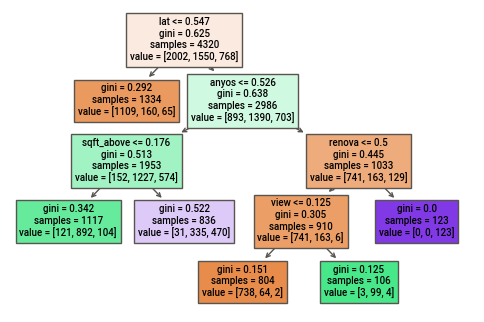

In [322]:
clf2 = DecisionTreeClassifier(max_leaf_nodes=6).fit(X_test, y_pred_list)
plot_tree(clf2, filled=True,feature_names=X.columns)
plt.show()

Las variables más determinantes para explicar la variabilidad del Cluster dentro de nuestros datos son...
##### Posicionamiento Geográfico
##### Antigüedad de la vivienda
##### Reforma
##### Metros Cuadrados
##### Número de Visitas 